In [1]:
import geopandas as gpd
import pandas as pd
from shapely.validation import make_valid

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Define functions

Defines two functions for analyzing geographic overlaps:

1. `compute_polygon_intersections()`: Computes new GeoDataFrame based on where boundaries overlap of two given GeoDataFrames
2. `process_multiple_overlays()`: Computes overlap between a list of GeoDataFrames

In [51]:
import geopandas as gpd
from shapely.validation import make_valid
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
import warnings

def clean_geometry(geom):
    """
    Clean and validate a geometry, handling various edge cases.
    
    Parameters:
    geom: Shapely geometry object
    
    Returns:
    Shapely geometry object: Cleaned and validated geometry
    """
    if geom is None:
        return None
        
    try:
        # First try to make the geometry valid
        valid_geom = make_valid(geom)
        
        # If the geometry is empty after validation, return None
        if valid_geom.is_empty:
            return None
            
        # Buffer by 0 to fix self-intersections and other topology issues
        buffered = valid_geom.buffer(0)
        
        # Handle different geometry types
        if isinstance(buffered, (Polygon, MultiPolygon)):
            return buffered
        elif hasattr(buffered, 'geoms'):
            # Extract only polygon/multipolygon geometries
            polygons = [g for g in buffered.geoms 
                       if isinstance(g, (Polygon, MultiPolygon))]
            if polygons:
                return unary_union(polygons)
        return None
    except Exception as e:
        warnings.warn(f"Geometry cleaning failed: {str(e)}")
        return None

def compute_polygon_intersections(gdf1, gdf2, target_crs='EPSG:5070'):
    """
    Compute all new polygons formed by overlaying two geodataframes with enhanced error handling.
    Uses Albers Equal Area projection (EPSG:5070) for accurate area calculations in the US.
    
    Parameters:
    gdf1 (GeoDataFrame): First geodataframe
    gdf2 (GeoDataFrame): Second geodataframe
    target_crs (str): Target CRS for accurate area calculations (default: EPSG:5070 - Albers Equal Area)
    
    Returns:
    GeoDataFrame: A geodataframe containing all intersection polygons
    """
    # Make copies to avoid modifying the original dataframes
    gdf1 = gdf1.copy()
    gdf2 = gdf2.copy()
    
    # Input validation
    if not isinstance(gdf1, gpd.GeoDataFrame) or not isinstance(gdf2, gpd.GeoDataFrame):
        raise ValueError("Both inputs must be GeoDataFrames")
    
    if len(gdf1) == 0 or len(gdf2) == 0:
        warnings.warn("One or both GeoDataFrames are empty")
        return None
    
    # Clean and validate geometries
    gdf1['geometry'] = gdf1['geometry'].apply(clean_geometry)
    gdf2['geometry'] = gdf2['geometry'].apply(clean_geometry)
    
    # Remove any rows where geometry cleaning failed
    gdf1 = gdf1.dropna(subset=['geometry'])
    gdf2 = gdf2.dropna(subset=['geometry'])
    
    if len(gdf1) == 0 or len(gdf2) == 0:
        warnings.warn("No valid geometries remain after cleaning")
        return None
    
    # Ensure CRS is set
    if gdf1.crs is None or gdf2.crs is None:
        warnings.warn("CRS not set for one or both GeoDataFrames")
        return None
    
    # Project to target CRS for accurate area calculations
    try:
        if gdf1.crs != target_crs:
            gdf1 = gdf1.to_crs(target_crs)
        if gdf2.crs != target_crs:
            gdf2 = gdf2.to_crs(target_crs)
    except Exception as e:
        warnings.warn(f"CRS transformation failed: {str(e)}")
        return None
    
    # Perform the overlay operation with error handling
    try:
        intersection_gdf = gpd.overlay(
            gdf1, 
            gdf2, 
            how='intersection',
        )
    except Exception as e:
        warnings.warn(f"Overlay operation failed: {str(e)}")
        return None
    
    if len(intersection_gdf) == 0:
        warnings.warn("No intersections found between the geometries")
        return None
    
    # Filter for polygon/multipolygon geometries
    polygon_types = ['Polygon', 'MultiPolygon']
    intersection_gdf = intersection_gdf[
        intersection_gdf.geometry.geom_type.isin(polygon_types)
    ]
    
    # Final geometry validation
    intersection_gdf['geometry'] = intersection_gdf['geometry'].apply(clean_geometry)
    intersection_gdf = intersection_gdf.dropna(subset=['geometry'])
    
    if len(intersection_gdf) == 0:
        warnings.warn("No valid polygons remain after final cleaning")
        return None
    
    # Add area calculations
    intersection_gdf['area_sq_meters'] = intersection_gdf.geometry.area
    
    # Add a unique identifier for each new polygon
    intersection_gdf['intersection_id'] = range(1, len(intersection_gdf) + 1)
    
    # Calculate the percentage of overlap with original polygons
    for i, original_gdf in enumerate([gdf1, gdf2], 1):
        overlap_areas = []
        for geom in intersection_gdf.geometry:
            try:
                # Find all intersecting polygons from original
                intersecting = original_gdf[original_gdf.intersects(geom)]
                if len(intersecting) > 0:
                    original_area = intersecting.iloc[0].geometry.area
                    overlap_areas.append(
                        (geom.area / original_area * 100) if original_area > 0 else 0
                    )
                else:
                    overlap_areas.append(0)
            except Exception:
                overlap_areas.append(0)
        
        intersection_gdf[f'overlap_percent_{i}'] = overlap_areas
    
    return intersection_gdf

def process_multiple_overlays(*gdfs, target_crs='EPSG:5070'):
    """
    Process multiple overlays in sequence with enhanced error handling.
    
    Parameters:
    *gdfs: Variable number of GeoDataFrames
    target_crs (str): Target CRS for accurate area calculations
    
    Returns:
    list: List of processed GeoDataFrames, where each entry is the result of
          overlaying the previous result with the next input GeoDataFrame
    """
    if len(gdfs) <= 1:
        return list(gdfs)
    
    merged_gdfs = [gdfs[0]]
    for i, gdf in enumerate(gdfs[1:], 1):
        result = compute_polygon_intersections(merged_gdfs[-1], gdf, target_crs)
        if result is None:
            warnings.warn(f"Overlay operation failed at step {i}")
            return merged_gdfs
        merged_gdfs.append(result)
    
    return merged_gdfs

# Load data

Load geographic boundary files (source: https://www2.census.gov/geo/tiger/TIGER2024/) and process overlaps between:
- Counties
- ZIP codes
- Congressional districts

In [52]:
# Load data
county_gdf = gpd.read_file('data/raw/tl_2024_us_county/tl_2024_us_county.shp')
zip_gdf = gpd.read_file('data/raw/tl_2020_us_zcta520/tl_2020_us_zcta520.shp')
district_gdf = gpd.read_file('data/raw/cb_2022_us_cd118_20m/cb_2022_us_cd118_20m.shp')

# Process the overlays
county_results, county_zip_results, county_zip_district_results = process_multiple_overlays(county_gdf, zip_gdf, district_gdf)

/var/folders/jq/t9yd781506l5nzb9j3y9rrtm0000gn/T/ipykernel_23436/2540302427.py:99: UserWarning: `keep_geom_type=True` in overlay resulted in 51322 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersection_gdf = gpd.overlay(
/var/folders/jq/t9yd781506l5nzb9j3y9rrtm0000gn/T/ipykernel_23436/2540302427.py:99: UserWarning: `keep_geom_type=True` in overlay resulted in 12313 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersection_gdf = gpd.overlay(


In [328]:
# Select and rename the columns
simplified_gdf = county_zip_district_results[['intersection_id', 'ZCTA5CE20', 'NAME', 'CD118FP', 'geometry',
                                              'STATEFP_1', 'STATEFP_2']].copy()

# Rename the columns for clarity
simplified_gdf = simplified_gdf.rename(columns={
    'ZCTA5CE20': 'zip',
    'NAME': 'county',
    'CD118FP': 'district',
    'STATEFP_1': 'county_state',
    'STATEFP_2': 'district_state'
})

# Resolve existing coordinates to intersected areas

Functions to find which geographic area contains a given latitude/longitude point:
- `find_containing_area()`: Core geospatial lookup function
- `find_containing_area_details()`: User-friendly wrapper for getting area detailsf

In [329]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

def find_containing_area(lat, lon, gdf, source_crs='EPSG:4326'):
    """
    Find if a lat-long point is contained within any polygon in the GeoDataFrame
    and return the matching record(s).
    
    Parameters:
    lat (float): Latitude of the point
    lon (float): Longitude of the point
    gdf (GeoDataFrame): GeoDataFrame containing polygons to check
    source_crs (str): CRS of the input coordinates (default: EPSG:4326 for standard lat-long)
    
    Returns:
    GeoDataFrame: Matching records where the point falls within the polygon
                 Returns None if no matches or if there's an error
    """
    try:
        # Input validation
        if not (-90 <= lat <= 90) or not (-180 <= lon <= 180):
            raise ValueError("Invalid latitude or longitude values")
        
        if not isinstance(gdf, gpd.GeoDataFrame):
            raise TypeError("Input must be a GeoDataFrame")
            
        # Create a Point from the coordinates
        point = Point(lon, lat)  # Note: Point takes (x,y) which is (lon,lat)
        
        # Create a GeoDataFrame from the point
        point_gdf = gpd.GeoDataFrame(
            geometry=[point],
            crs=source_crs
        )
        
        # If the GeoDataFrames have different CRS, transform the point to match the polygons
        if point_gdf.crs != gdf.crs:
            point_gdf = point_gdf.to_crs(gdf.crs)
        
        # Find all polygons that contain the point
        matches = gdf[gdf.geometry.contains(point_gdf.geometry[0])]
        
        if len(matches) == 0:
            return None
            
        return matches
        
    except Exception as e:
        print(f"Error processing point ({lat}, {lon}): {str(e)}")
        return None

def find_containing_area_details(lat, lon, gdf):
    """
    Wrapper function that returns a more user-friendly output.
    
    Parameters:
    lat (float): Latitude of the point
    lon (float): Longitude of the point
    gdf (GeoDataFrame): GeoDataFrame containing polygons to check
    
    Returns:
    dict: Dictionary containing the area details, or None if no match
    """
    matches = find_containing_area(lat, lon, gdf)
    
    if matches is None or len(matches) == 0:
        return None
        
    # Create list of matching areas
    results = []
    for _, row in matches.iterrows():
        result = {
            'intersection_id': row['intersection_id'],
            'zip': str(row['zip']),
            'county': row['county'],
            'district': str(row['district']),
        }
        results.append(result)
    
    return results

In [330]:
lat = 41.9158651
lon = -96.7885168

matches = find_containing_area(lat, lon, simplified_gdf)
if matches is not None:
    print("\nFull matching records:")
    print(matches)

# Simplified version with just the key details
results = find_containing_area_details(lat, lon, simplified_gdf)
if results is not None:
    print("\nSimplified results:")
    for result in results:
        print(f"ZIP: {result['zip']}")
        print(f"County: {result['county']}")
        print(f"Congressional District: {result['district']}")


Full matching records:
    intersection_id    zip  county district  \
13               14  68788  Cuming       01   

                                             geometry county_state  \
13  POLYGON ((-49258.372 2082214.53, -49330.616 20...           31   

   district_state  
13             31  

Simplified results:
ZIP: 68788
County: Cuming
Congressional District: 01


# Build lookup table

Associate coordinates previously used for Ballotpedia lookups by finding which census areas contain each ZIP code's coordinates

In [331]:
from tqdm import tqdm

tqdm.pandas()

intersection_latlng_lookup = {}
zip_latlng_lookup = {}
def fill_latlng_lookup(row):
    matches = find_containing_area_details(row.lat, row.lng, simplified_gdf)
    for match in matches or []:
        intersection_latlng_lookup[match['intersection_id']] = (row.lat, row.lng)
        zip_latlng_lookup[row.zip] = (row.lat, row.lng)
    return matches

df = pd.read_csv('data/raw/zip_code_demographics.csv')
df['matches'] = df.progress_apply(fill_latlng_lookup, axis=1)

100%|██████████████████████████████████████| 33704/33704 [00:57<00:00, 586.22it/s]


In [332]:
population_lookup = dict(zip(df.zip.astype(int), df.population))
state_lookup = {**dict(zip(df.zip.astype(int), df.state_name)), 32072: 'Florida', 97258: 'Oregon', 32026: 'Florida'}
state_id_lookup = {**dict(zip(df.zip.astype(int), df.state_id)), 32072: 'FL', 97258: 'OR', 32026: 'FL'}

simplified_gdf['population'] = simplified_gdf.zip.astype(int).map(population_lookup)
simplified_gdf['state'] = simplified_gdf.zip.astype(int).map(state_lookup)
simplified_gdf['state_id'] = simplified_gdf.zip.astype(int).map(state_id_lookup)

# Remove all NAs with zip codes starting with 00 (these are in Puerto Rico, which has no ballots)
simplified_gdf = simplified_gdf[~(simplified_gdf.zip.str.startswith('00') & simplified_gdf.state.isna())]

assert simplified_gdf.state.notna().all()

# Fix states for messed up intersections

In [306]:
county_state_lookup = dict(simplified_gdf.groupby('county_state').state_id.apply(lambda x: x.mode()[0]))
district_state_lookup = dict(simplified_gdf.groupby('district_state').state_id.apply(lambda x: x.mode()[0]))
len(county_state_lookup)
len(district_state_lookup)
county_state_lookup == district_state_lookup

simplified_gdf['county_state_id'] = simplified_gdf.county_state.map(county_state_lookup)
simplified_gdf['district_state_id'] = simplified_gdf.district_state.map(district_state_lookup)
simplified_gdf = simplified_gdf[
    (simplified_gdf.district_state_id == simplified_gdf.state_id) &
    (simplified_gdf.county_state_id == simplified_gdf.state_id)
].drop(columns=['county_state', 'district_state', 'county_state_id', 'district_state_id'])

51

51

True

In [307]:
missing_zip_df = demographics_df[(~demographics_df.zip.astype(str).isin(simplified_gdf.zip) & 
                                  ~demographics_df.zip.astype(str).str.startswith('00'))]
missing_zip_df.head()

,zip,lat,lng,city,state_id,state_name,population,density,county_name,po_box,dist_highway,dist2_large_airport,dist2_medium_airport,dist_to_shore,number_of_business,adjusted_gross_income,total_income_amount,number_of_returns
0,1001,42.06262,-72.62521,Agawam,MA,Massachusetts,16088,550.1,Hampden,0,1.387035,106.145765,12.946212,93.049251,438.0,598807,6.047690e+05,9320
1,1002,42.37633,-72.46462,Amherst,MA,Massachusetts,27323,198.1,Hampshire,0,14.438177,112.264368,21.080079,133.370144,571.0,989558,1.005796e+06,9880
2,1005,42.42117,-72.10655,Barre,MA,Massachusetts,4947,44.2,Worcester,0,16.788339,90.664964,25.547718,97.639881,97.0,164207,1.660540e+05,2490
3,1007,42.28163,-72.40009,Belchertown,MA,Massachusetts,15304,107.7,Hampshire,0,13.663839,101.552921,14.762395,114.406034,217.0,647074,6.547390e+05,7970
4,1008,42.18234,-72.95819,Blandford,MA,Massachusetts,1171,7.4,Hampden,0,2.593655,136.548797,20.177950,107.466779,18.0,47826,4.824100e+04,660


In [308]:
# Get centroids and convert to lat-lng if needed
if simplified_gdf.crs != 'EPSG:4326':
    # Convert to lat-lng projection first
    centroids = simplified_gdf.geometry.centroid.to_crs('EPSG:4326')
else:
    centroids = simplified_gdf.geometry.centroid

# Add the centerpoints of each intersection
simplified_gdf['center_latlng'] = [(c.y, c.x) for c in centroids]

In [309]:
# Use the new centerpoints as fallbacks
simplified_gdf['lookup_latlng'] = simplified_gdf.intersection_id.map(match_lookup).fillna(simplified_gdf.center_latlng)

In [310]:
max_id = county_zip_district_results.intersection_id.max().astype(int)
missing_zip_df['intersection_id'] = list(range(max_id + 1, max_id + len(missing_zip_df) + 1))
simplified_gdf = pd.concat([
    simplified_gdf,
    pd.DataFrame(missing_zip_df.apply(
        lambda row: {'intersection_id': row.intersection_id, 'zip': row.zip, 'county': row.county_name,
                     'population': row.population, 'state': row.state_name, 'state_id': row.state_id,
                     'center_latlng': (row.lat, row.lng), 'lookup_latlng': (row.lat, row.lng)},
        axis=1
    ).to_list())
])

/var/folders/jq/t9yd781506l5nzb9j3y9rrtm0000gn/T/ipykernel_23436/2834953364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_zip_df['intersection_id'] = list(range(max_id + 1, max_id + len(missing_zip_df) + 1))


# Get street maps

In [285]:
import folium
import numpy as np
from typing import List, Dict, Tuple
import random

def generate_distinct_colors(n: int) -> List[str]:
    """
    Generate n visually distinct colors using a professional color palette
    """
    colors = [
        '#4e79a7',  # Blue
        '#f28e2b',  # Orange
        '#59a14f',  # Green
        '#e15759',  # Red
        '#76b7b2',  # Teal
        '#6c5b7b',  # Purple
        '#b07aa1',  # Pink
        '#9c755f',  # Brown
        '#86bcb6',  # Light teal
        '#4b4b8f',  # Navy
    ]
    while len(colors) < n:
        colors.append(colors[len(colors) % len(colors)])
    return colors[:n]

def create_map_with_polygons(polygons_data: List[Dict], zoom_start: int = None, filename: str = 'map_with_polygons'):
    """
    Create an interactive map with multiple labeled polygons
    
    Args:
        polygons_data: List of dictionaries, each containing:
            - 'coordinates': List of [longitude, latitude] coordinates
            - 'name': Name of the polygon
            - 'additional_info': (optional) Additional information for popup
        zoom_start: Initial zoom level (optional, will auto-fit if None)
    
    Returns:
        Path to saved HTML file
    """
    # Calculate center point from all polygons
    all_lats = [coord[1] for poly in polygons_data 
                for coord in poly['coordinates']]
    all_lons = [coord[0] for poly in polygons_data 
                for coord in poly['coordinates']]

    if not all_lats or not all_lons:
        return None

    center_lat = np.mean(all_lats)
    center_lon = np.mean(all_lons)
    
    # Create base map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=zoom_start if zoom_start is not None else 13,
        tiles='CartoDB positron',
        control_scale=True
    )
    
    # Get unique names and assign colors
    unique_names = list(set(poly['name'] for poly in polygons_data))
    colors = generate_distinct_colors(len(unique_names))
    name_to_color = dict(zip(unique_names, colors))
    
    # Calculate bounds for all polygons
    sw_bound = [min(all_lats), min(all_lons)]
    ne_bound = [max(all_lats), max(all_lons)]
    
    # Add polygons to map
    for poly_data in polygons_data:
        folium_coords = [[lat, lon] for lon, lat in poly_data['coordinates']]
        color = name_to_color[poly_data['name']]
        
        popup_content = f"""
            <div style="font-family: Arial, sans-serif;">
                <h4 style="margin:0 0 5px 0;">{poly_data['name']}</h4>
                {f'<p style="margin:0;">{poly_data["additional_info"]}</p>' if 'additional_info' in poly_data else ''}
            </div>
        """
        
        folium.Polygon(
            locations=folium_coords,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.2,
            weight=2,
            popup=folium.Popup(popup_content, max_width=300),
            tooltip=poly_data['name']
        ).add_to(m)
    
    # Fit the map to the bounds of all polygons with some padding
    m.fit_bounds([sw_bound, ne_bound], padding=(30, 30))
    
    # Create legend with unique entries
    legend_html = """
        <div style="
            position: fixed;
            bottom: 50px;
            right: 50px;
            z-index: 1000;
            background-color: white;
            padding: 10px;
            border: 2px solid rgba(0,0,0,0.2);
            border-radius: 4px;
            font-family: Arial, sans-serif;
            font-size: 12px;
            max-width: 200px;
            box-shadow: 0 1px 5px rgba(0,0,0,0.2);
            ">
            <div style="font-weight: bold; margin-bottom: 10px;">Areas</div>
    """
    
    # Add legend items for unique names only
    for name, color in name_to_color.items():
        legend_html += f"""
            <div style="
                display: flex;
                align-items: center;
                margin-bottom: 5px;
                white-space: nowrap;
                overflow: hidden;
                text-overflow: ellipsis;
            ">
                <span style="
                    display: inline-block;
                    width: 12px;
                    height: 12px;
                    margin-right: 8px;
                    background: {color};
                    opacity: 0.7;
                    border-radius: 2px;
                "></span>
                <span>{name}</span>
            </div>
        """
    
    legend_html += "</div>"
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Save the map
    output_file = f'{filename}.html'
    m.save(f'data/processed/{output_file}')
    return output_file

In [286]:
import pyproj
from typing import List, Tuple

def albers_to_latlon(coords: List[Tuple[float, float]]) -> List[List[float]]:
    """
    Convert coordinates from NAD83 / Conus Albers (EPSG:5070) to WGS84 latitude/longitude
    
    Args:
        coords: List of (x, y) tuples in Albers projection (meters)
        
    Returns:
        List of [longitude, latitude] coordinates
    """
    # Create transformer from NAD83 / Conus Albers to WGS84
    transformer = pyproj.Transformer.from_crs(
        "EPSG:5070",  # NAD83 / Conus Albers
        "EPSG:4326",  # WGS84
        always_xy=True
    )
    
    # Transform coordinates
    latlon_coords = []
    for x, y in coords:
        lon, lat = transformer.transform(x, y)
        if np.isnan(lat) or np.isnan(lon):
            continue
        latlon_coords.append([lon, lat])
    
    return latlon_coords


In [289]:
import shapely
from shapely.ops import transform
import numpy as np

def get_polygon_min_width(polygon):
    """
    Estimates the minimum width of a polygon by sampling points and finding
    minimum distance to boundary. This is an approximation but works well
    for detecting narrow slivers.
    
    Args:
        polygon: shapely Polygon object
    Returns:
        float: Approximate minimum width of the polygon
    """
    if not polygon:
        return None
        
    if not polygon.is_valid:
        return 0
    
    # Get a grid of points inside the polygon
    minx, miny, maxx, maxy = polygon.bounds
    x_range = np.linspace(minx, maxx, 20)
    y_range = np.linspace(miny, maxy, 20)
    xx, yy = np.meshgrid(x_range, y_range)
    points = [shapely.Point(x, y) for x, y in zip(xx.flat, yy.flat)]
    
    # Filter to points inside the polygon
    points = [p for p in points if polygon.contains(p)]
    
    if not points:
        return 0
    
    # Calculate distance to boundary for each point
    distances = [polygon.boundary.distance(p) for p in points]
    
    # Return maximum distance (represents half the minimum width)
    return max(distances) * 2

# Modified version of your original code
polygon_lookup = simplified_gdf.groupby('zip').progress_apply(
    lambda df: df.apply(lambda row: [{
        'name': f' {row.county} - {row.state_id}-CD{row.district}'.replace('00', '01'),
        'coordinates': albers_to_latlon(x.exterior.coords)
    } for x in (
        row.geometry.geoms if type(row.geometry) == shapely.geometry.multipolygon.MultiPolygon
        else [row.geometry]
    ) if (get_polygon_min_width(x) or 0) > 1e-10  # Adjust threshold as needed (in same units as your CRS)
    ], axis=1).sum()
)

100%|███████████████████████████████████████| 36151/36151 [26:07<00:00, 23.06it/s]


In [290]:
# Omit insignificant regions (e.g. streets)
simplified_gdf['best_width'] = simplified_gdf.geometry.progress_apply(
    lambda x: max([get_polygon_min_width(y) for y in (
        [x] if type(x) != shapely.geometry.multipolygon.MultiPolygon
        else x.geoms
    )])
)

100%|███████████████████████████████████████| 63374/63374 [17:10<00:00, 61.48it/s]


In [291]:
# simplified_gdf = 
# simplified_gdf.best_width.plot.hist(bins=1000)
len(simplified_gdf)
sample_gdf = simplified_gdf[(simplified_gdf.best_width > 10) | simplified_gdf.best_width.isna()]
len(sample_gdf)

63374

59527

10.016370124340668

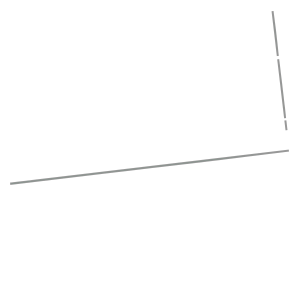

'46919'

In [292]:
sample_gdf.sort_values(by='best_width').iloc[0].best_width
sample_gdf.sort_values(by='best_width').iloc[0].geometry
sample_gdf.sort_values(by='best_width').iloc[0].zip

In [293]:
output_lookup = {}
for zip_code, x in dict(polygon_lookup).items():
    if len(set(y['name'] for y in x)) > 1:
        output_file = create_map_with_polygons(x, filename=zip_code)
        output_lookup[zip_code] = output_file

In [294]:
import os
for x in os.listdir('data/processed'):
    if x.endswith('html'):
        if x.split('.')[-2] not in output_lookup:
            os.remove(f'data/processed/{x}')

In [295]:
sample_gdf['link'] = sample_gdf.zip.map(output_lookup).apply(
    lambda x: f'https://edbltn.github.io/show-me-the-ballot/data/processed/{x}')

/Users/ericbolton/Documents/showballot/env/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [296]:
sample_gdf.to_file('data/processed/areas.shp', index=False)

/var/folders/jq/t9yd781506l5nzb9j3y9rrtm0000gn/T/ipykernel_23436/1250419676.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  sample_gdf.to_file('data/processed/areas.shp', index=False)
/Users/ericbolton/Documents/showballot/env/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'intersection_id' to 'intersecti'
  ogr_write(
/Users/ericbolton/Documents/showballot/env/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'center_latlng' to 'center_lat'
  ogr_write(
/Users/ericbolton/Documents/showballot/env/lib/python3.12/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'lookup_latlng' to 'lookup_lat'
  ogr_write(
